In [2]:
import pandas as pd
import geopandas as gpd
import glob
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib nbagg


In [3]:
intersection = gpd.read_file(r'J:\Geology\WSGS\GIS\elevation_intersection.shp') #reads in the hydraulic basin units and adds an area column
intersection = intersection.to_crs({'init': 'epsg:3732'})

In [4]:
possible_areas = intersection[((intersection['SURFACE'] == 'State') | (intersection['SURFACE'] == 'State (University of Wyoming)')
         |(intersection['SURFACE'] == 'State (Wyoming Game & Fish)') |(intersection['SURFACE'] == 'State (State Parks & Hist Sites)')
          |(intersection['SURFACE'] == 'Bureau of Land Management') |(intersection['SURFACE'] == 'Forest Service')) &
            intersection['gridcode'] == 1]

In [5]:
#possible_areas.to_file(driver='ESRI Shapefile', filename='open_land_and_elevation.shp')


In [6]:
faults = gpd.read_file(r'J:\Geology\WSGS\GIS\Faults.shp') #reads in the hydraulic basin units and adds an area column
faults = faults.to_crs({'init': 'epsg:3732'})

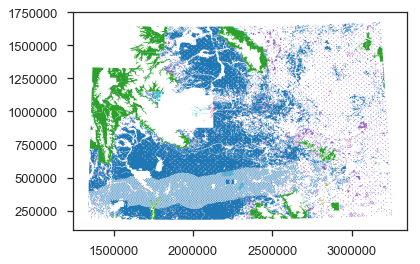

In [7]:
fig, ax = plt.subplots()
possible_areas.plot(column='SURFACE', ax=ax)
#faults.plot(color='k', ax=ax)

In [8]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\probability maps\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed)
crustal_abundance=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\crustal_abundance.csv',encoding = "ISO-8859-1")
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})


counties = gpd.read_file(r'J:\Geology\WSGS\GIS\County_boundaries_polys.shp')
counties = counties.to_crs({'init': 'epsg:3732'})

roads = gpd.read_file(r'J:\Geology\WSGS\GIS\Highway_road.shp')
roads = roads.to_crs({'init': 'epsg:3732'})

frame['HUC_12']=frame.HUC_12.astype(str)
CaptainHucstable = huc12.merge(frame, on='HUC_12' )
pruned = CaptainHucstable[CaptainHucstable['prob']>0]

In [60]:
#this section pools the formations and elements, we can tune this to search for specific elements

formations = sorted(CaptainHucstable['formation'].unique().tolist())
elements = sorted(CaptainHucstable['element'].unique().tolist())
masterList = []
for i in tqdm(range(len(formations))):
    listed2 = []
    for element in elements:
        ind = pruned[(pruned['formation']== formations[i]) & (pruned['element']==element) & (
               pruned['prob']>=0.6) & (pruned['bins_ppm']>=crustal_abundance[element][5]*5)].index
        listed2.append(pruned.loc[ind])
    frame2 = pd.DataFrame
    frame2 = pd.concat(listed2)
    df3 = frame2.dissolve(by='HUC_12', aggfunc='sum')
    df3['formation'] = formations[i]
    masterList.append(df3)
    
masterFrame = pd.DataFrame
masterFrame = pd.concat(masterList)

100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [48:09<00:00, 13.89s/it]


In [61]:
pooledFormations = masterFrame.dissolve(by='WY_HU12_ID', aggfunc='sum') #dissolve to each HUC
#pooledFormations.to_file(driver='ESRI Shapefile', filename='pooled_formations_60prob.shp') #then writes it to file

In [62]:
#pooledFormations = gpd.read_file(r'J:\Geology\WSGS\GIS\pooled_formations.shp') #reads in the hydraulic basin units and adds an area column
pooledFormations = pooledFormations.to_crs({'init': 'epsg:3732'})

counties = gpd.read_file(r'J:\Geology\WSGS\GIS\County_boundaries_polys.shp')
counties = counties.to_crs({'init': 'epsg:3732'})

<IPython.core.display.Javascript object>


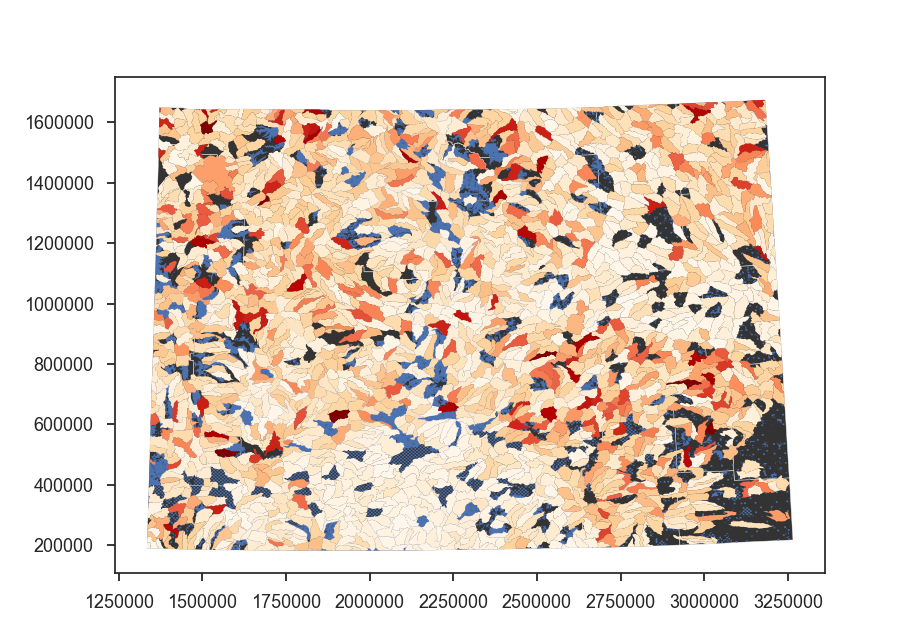

In [65]:
fig, ax = plt.subplots()
counties.plot(ax=ax, alpha=0.8, color='black', edgecolor='white')
possible_areas.plot(ax=ax)

pooledFormations.plot(column='prob',cmap='OrRd', ax=ax)


<IPython.core.display.Javascript object>


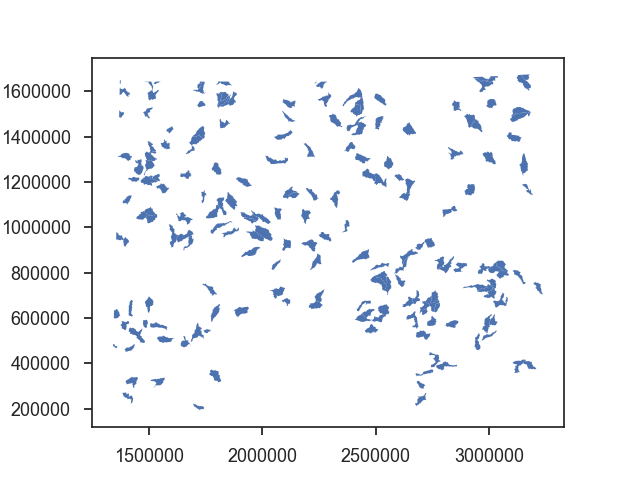

In [70]:
pooledFormations[pooledFormations['prob']>60].plot()

In [9]:
#this section is pulled from the geopandas github https://github.com/geopandas/geopandas/issues/400 that speeds up overlay
#this version runs in <3% of the time of the original, which means minutes instead of days for this dataset.
import geopandas as gp

def spatial_overlays(df1, df2, how='intersection'):
    '''Compute overlay intersection of two 
        GeoPandasDataFrames df1 and df2
    '''
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['histreg'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        
        pairs = gp.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gp.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('histreg')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gp.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), [x.geometry]+list(df2.iloc[x.histreg].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'histreg', new_g], axis=1, inplace=True)
        return df1

In [71]:
intersections = spatial_overlays(possible_areas, pooledFormations, how='intersection') #calculates the intersection of bedrock and drainage

<IPython.core.display.Javascript object>


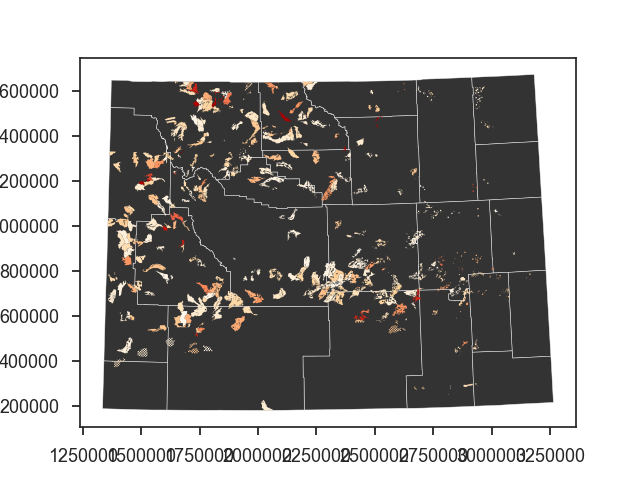

In [75]:
fig, ax = plt.subplots()
counties.plot(ax=ax, alpha=0.8, color='black', edgecolor='white')
intersections.plot(column='prob', ax=ax, cmap='OrRd')

<IPython.core.display.Javascript object>


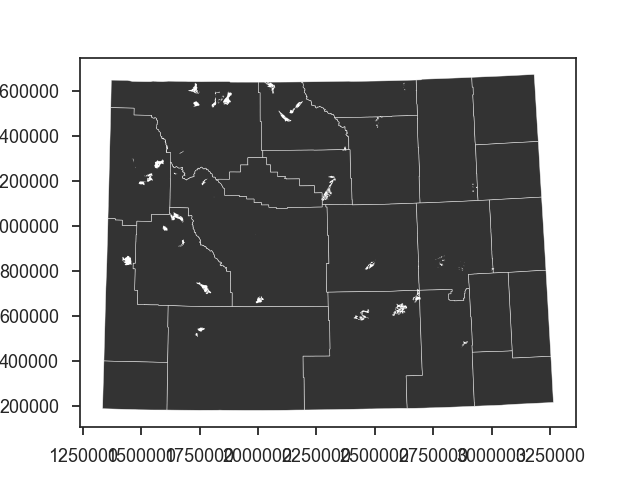

In [78]:
%matplotlib notebook

fig, ax = plt.subplots()
counties.plot(ax=ax, alpha=0.8, color='black', edgecolor='white')
intersections[intersections['prob']>55].plot( ax=ax, color='white')
#faults.plot(color='green', ax=ax)

In [30]:
targets = intersections[intersections['prob']>60]

In [29]:
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})

In [31]:
sample_locations = gpd.sjoin(targets, huc12)

In [35]:
sample_locations

,idx1,idx2,FID_lessth,Id,gridcode,FID_BLM__S,OBJECTID,SURFACE,HOLDAGENCY,SMA_ID,...,HU_12_DS,HU_12_NAME,HU_12_MOD,HU_12_TYPE,HU_2_NAME,HU_4_NAME,HU_6_NAME,HU_8_NAME,Shape_Leng,Shape_Area
20812,5247,125,469,470,1,4084,4085,State,None,2386,...,101800081102,Upper Broom Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.548397,0.011772
122290,16185,125,469,470,1,15234,15235,Bureau of Land Management,None,2,...,101800081102,Upper Broom Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.548397,0.011772
124716,16373,125,469,470,1,15422,15423,Bureau of Land Management,None,2,...,101800081102,Upper Broom Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.548397,0.011772
20812,5247,125,469,470,1,4084,4085,State,None,2386,...,101800080705,Upper Willow Creek-Middle Willow Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.637516,0.012506
21479,5285,125,469,470,1,4122,4123,State,None,2386,...,101800080705,Upper Willow Creek-Middle Willow Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.637516,0.012506
21695,5299,125,469,470,1,4136,4137,State,None,2386,...,101800080705,Upper Willow Creek-Middle Willow Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.637516,0.012506
22195,5330,125,469,470,1,4167,4168,State,None,2386,...,101800080705,Upper Willow Creek-Middle Willow Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.637516,0.012506
24620,5475,125,469,470,1,4312,4313,State,None,2386,...,101800080705,Upper Willow Creek-Middle Willow Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.637516,0.012506
29467,5766,125,469,470,1,4603,4604,State,None,2386,...,101800080705,Upper Willow Creek-Middle Willow Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.637516,0.012506
30063,5801,125,469,470,1,4638,4639,State,None,2386,...,101800080705,Upper Willow Creek-Middle Willow Creek,NM,S,Missouri,North Platte,North Platte,Glendo Reservoir,0.637516,0.012506


In [39]:
#sample_locations.to_file(driver='ESRI Shapefile', filename='sample_locations.shp')

# What if we want a specific mineral?

In [24]:
formations = sorted(CaptainHucstable['formation'].unique().tolist())
element = 'sb_ppm' #choose your element

specificElementList = []
for i in tqdm(range(len(formations))):
    
    ind = pruned[(pruned['formation']== formations[i]) & (pruned['element']==element) & (
               pruned['prob']>=0.5) & (pruned['bins_ppm']>=crustal_abundance[element][5]*5)].index
    specificElementList.append(pruned.loc[ind])
dframe3 = pd.DataFrame
dframe3= pd.concat(specificElementList)
dframe3 = dframe3.dissolve(by='HUC_12', aggfunc='sum')

100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:52<00:00,  3.94it/s]


In [25]:
pooledSpecificElement = dframe3.dissolve(by='WY_HU12_ID', aggfunc='sum') #dissolve to each HUC
pooledSpecificElement = pooledSpecificElement.to_crs({'init': 'epsg:3732'})

#pooledSpecificElement.to_file(driver='ESRI Shapefile', filename='pooled_formations_60prob.shp') #then writes it to file

In [26]:
accessible = spatial_overlays(possible_areas, pooledSpecificElement, how='intersection') #calculates the intersection of bedrock and drainage

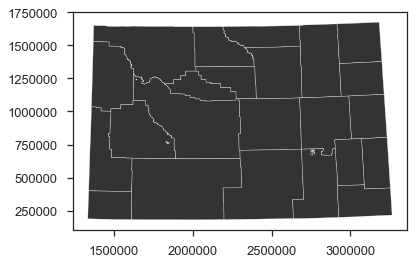

In [28]:
fig, ax = plt.subplots()
percentile=np.percentile(sorted(accessible.prob.unique()), 80)
counties.plot(ax=ax, alpha=0.8, color='black', edgecolor='white')
accessible[accessible['prob']>percentile].plot( ax=ax, color='white')

In [13]:
accessible['element'] = element
accessible.head()

,idx1,idx2,FID_lessth,Id,gridcode,FID_BLM__S,OBJECTID,SURFACE,HOLDAGENCY,SMA_ID,...,PERIMETER,WY_HU12_,ACRES,NCONTRB_A,Shape_Leng_2,Shape_Area_2,bins_ppm,prob,geometry,element
209530,17173,310,469,470,1,16222,16223,Bureau of Land Management,None,2,...,1.236771,3866,63525.767987,0.0,1.236771,0.027976,2.0,1.466667,"POLYGON ((1743146.08025937 552744.0779629808, ...",sb_ppm
303469,20826,471,469,470,1,19901,19902,Bureau of Land Management,None,2,...,1.254571,1317,32912.726691,0.0,1.254571,0.015106,3.0,1.500000,"POLYGON ((1945246.724687771 1520806.878170165,...",sb_ppm
11758,4251,448,469,470,1,3088,3089,State,None,2386,...,7.220329,20540,282809.988392,0.0,7.220329,0.125236,12.0,7.333333,"POLYGON ((2773533.807529745 703270.8818029653,...",sb_ppm
12652,4302,448,469,470,1,3139,3140,State,None,2386,...,7.220329,20540,282809.988392,0.0,7.220329,0.125236,12.0,7.333333,"POLYGON ((2760148.883588674 673841.5592570339,...",sb_ppm
13472,4346,448,469,470,1,3183,3184,State,None,2386,...,7.220329,20540,282809.988392,0.0,7.220329,0.125236,12.0,7.333333,"POLYGON ((2776984.883984714 682314.8645661672,...",sb_ppm


# The next cell selects each element with a probability greater than 50% and masks it with the public land shapefile. After that it selects the areas with in the top 20% probability

In [31]:
formations = sorted(CaptainHucstable['formation'].unique().tolist())
elements = sorted(CaptainHucstable['element'].unique().tolist())

for elment in elements:
    try:
        specificElementList = []
        for i in tqdm(range(len(formations))):
            ind = pruned[(pruned['formation']== formations[i]) & (pruned['element']==elment) & (pruned['prob']>=0.5) & (pruned['bins_ppm']>=crustal_abundance[element][5]*5)].index
            specificElementList.append(pruned.loc[ind])
        dframe3 = pd.DataFrame
        dframe3= pd.concat(specificElementList)
        dframe3 = dframe3.dissolve(by='HUC_12', aggfunc='sum')
        pooledSpecificElement = dframe3.dissolve(by='WY_HU12_ID', aggfunc='sum') #dissolve to each HUC
        pooledSpecificElement = pooledSpecificElement.to_crs({'init': 'epsg:3732'})
        accessible = spatial_overlays(possible_areas, pooledSpecificElement, how='intersection') #calculates the intersection of bedrock and drainage
        accessible['element'] = elment
        percentile=np.percentile(sorted(accessible.prob.unique()), 80)
        samploc = accessible[accessible['prob']>percentile]
        samploc.to_file(driver='ESRI Shapefile', filename=str(elment)+'.shp')
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:54<00:00,  3.85it/s]
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x0000022A75DAD0F0>>
Traceback (most recent call last):
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\rtree\index.py", line 875, in __del__
    self.destroy()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\rtree\index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:54<00:00,  3.79it/s]
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x0000022A78CD09B0>>
Traceback (most recent call last):
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\rtree\index.py", line 8